# Notebook to generate plots of ranking after round 1 and 2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz
import calibr8
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pyrff
import string

try:
    import pymc3
except:
    import pymc as pymc3

import cutisplit
import run_analysis

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%load_ext watermark
%watermark --iversions

cutisplit : 0.2.0
pymc      : 4.0.0b2
arviz     : 0.11.4
numpy     : 1.20.3
matplotlib: 3.5.0
pyrff     : 2.0.1
pandas    : 1.3.4
calibr8   : 6.5.2



Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 3 does not exist and loop will be exited
Error while reading the files. Repetition 3 does not exist and loop will be exited


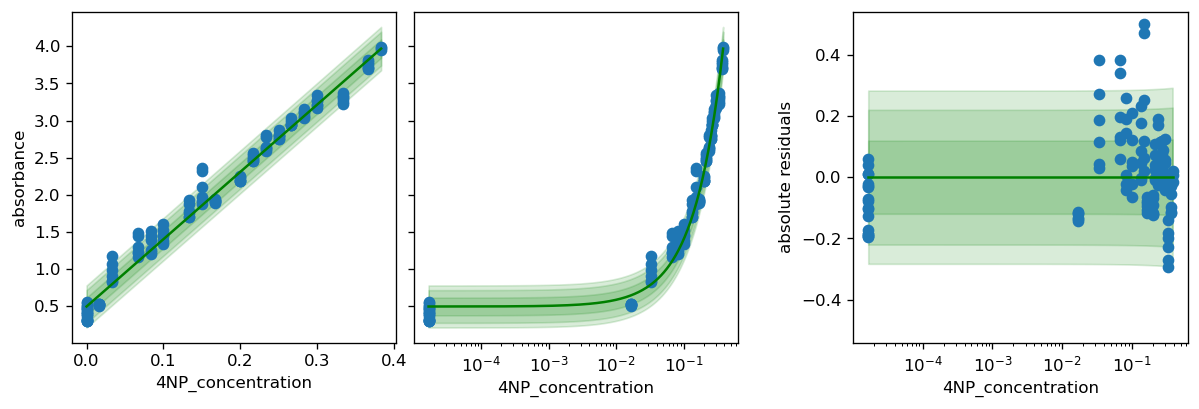

In [4]:
RUN_ID = "C3C1XZ" #TODO: Replace by the latest round you want to include in analysis.
variant = "LCC" #TODO: Change to PE-H for alternative results
resultpath = f'{RUN_ID}_Results' 
parent_dir = pathlib.Path(os.getcwd()).parent
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(
    rf"{parent_dir}\data_analysis\{resultpath}\{RUN_ID}_cm_nitrophenol.json"
)
calibr8.plot_model(cm_nitrophenol)


df_inputs, df_kinetics = run_analysis.read_rounds([
    "BWA7DQ", "BZACW9", "C3C1XZ"
    #"BWNZ99", "BZP1XQ", "C4PZHQ" #TODO: Exchange for PE-H
])

## Creating the Model

In [5]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC model:
model.summary()

c:\users\helleckes\repos\pymc\pymc\data.py:640: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


strain              (24,)	AbnA30, AmyE30, AprE30, …, YwmC30
culture_id          (84,)	BWA7DQ_A02, BWA7DQ_A04, BWA7DQ_A05, …, C3C1XZ_F07
kinetic_id          (336,)	BWA7DQ_1_B01, BWA7DQ_1_B02, BWA7DQ_1_B03, …, C3C1XZ_2_G12
column_id           (12,)	1, 2, 3, …, 12
cutinase_cycle      (30,)	0, 1, 2, …, 29


## Load data for round 1 and round 2 individually for comparison

In [6]:
idata2 = arviz.from_netcdf(
    rf"{parent_dir}\data_analysis\{resultpath}\{RUN_ID}_{variant}_round2.nc"
)
#Replace BZACW9 by BZP1XQ for alternative PE-H analysis
idata1 = arviz.from_netcdf(
    rf"{parent_dir}\data_analysis\BZACW9_Results\BZACW9_{variant}_round1.nc"
)

## Plot rankings for both rounds

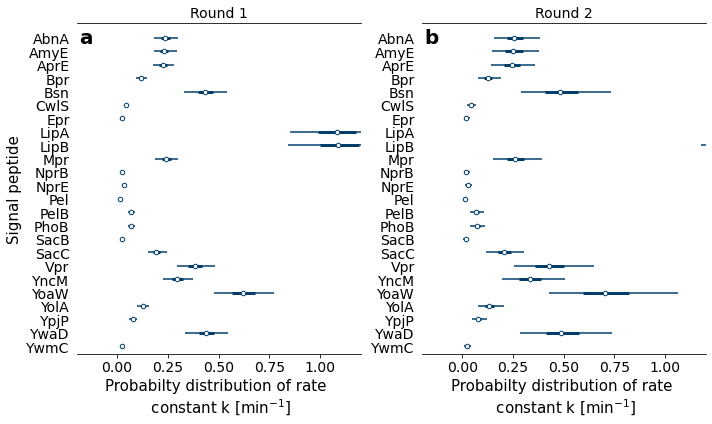

In [7]:
fig, axs = pyplot.subplots(figsize=(10,6), ncols=2)
for i, (idat, ax) in enumerate(zip([idata1, idata2], axs.flatten())):
    arviz.plot_forest(idat, var_names=["k"], combined=True, ax=ax, colors=["#023D6B"])
    ax.set_xlabel("Probabilty distribution of rate \n constant k [min$^{-1}$]", size=15)
    strains = numpy.unique([
        strain[:-2]
        for strain in df_inputs.strain.values
])
    ax.set_yticklabels(strains[::-1])
    ax.set_xlim(-0.2, 1.2)
    ax.text(0.01, 0.94, string.ascii_lowercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    ax.set_title(f"Round {i+1}", size=14)
axs[0].set_ylabel("Signal peptide", size=15)
pyplot.tight_layout()
pyplot.savefig(f"{variant}_kprobs_round1+2.png", dpi=200)

## Stack posterior (combine chains and draws of MCMC) for simpler analysis

In [8]:
posterior1 = idata1.posterior.stack(sample=("chain", "draw"))
posterior2 = idata2.posterior.stack(sample=("chain", "draw"))
probs1 = pyrff.sampling_probabilities(
    posterior1.k.values,
    correlated=True
)
probs2 = pyrff.sampling_probabilities(
    posterior2.k.values,
    correlated=True
)

## Plot probabilities for each variant to be the best

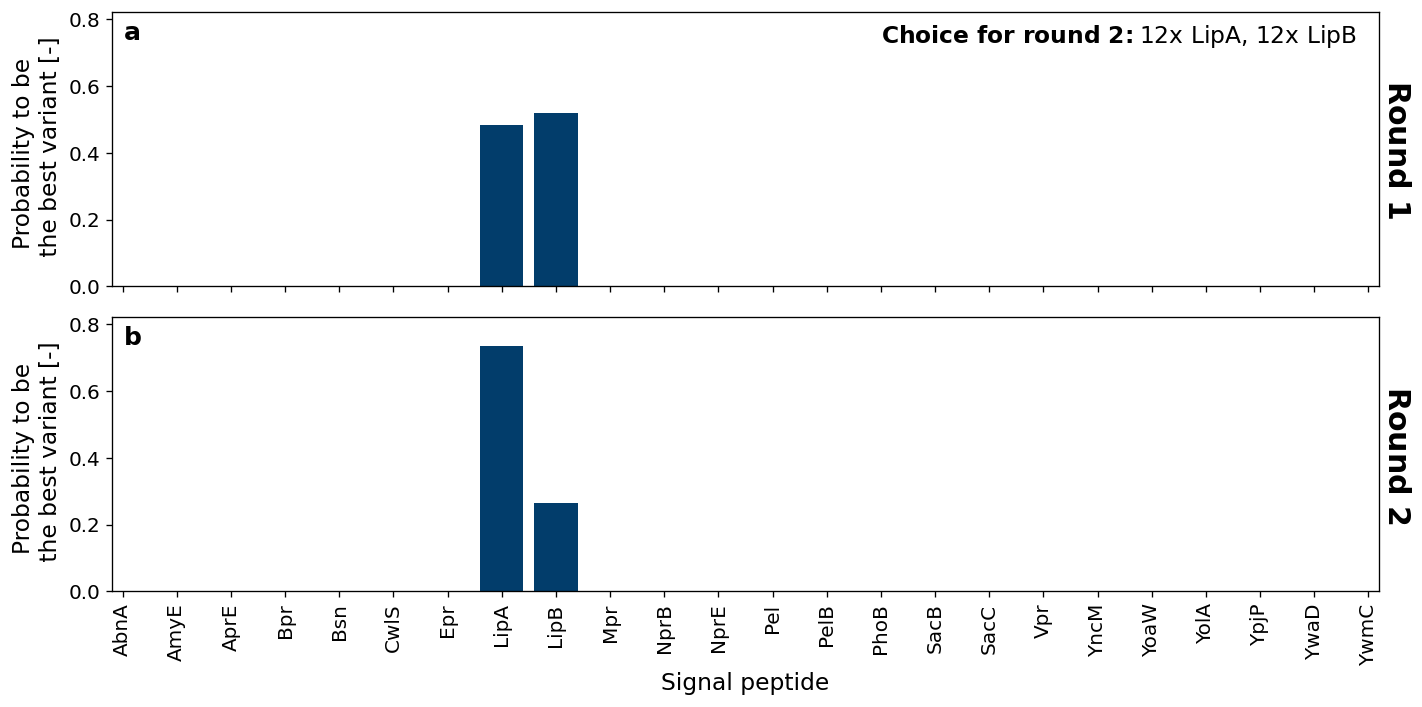

In [9]:
old_strains= [
    strain.split("3")[0]
    for strain in numpy.unique(df_inputs.strain.values)
]

fig, axs = pyplot.subplots(figsize=(12,6), dpi=120, nrows=2, sharex=True)
# Plot round 1
ax= axs[0]
ax.bar(x=numpy.arange(len(probs1)), height=probs1, color="#023D6B")
ax.set_xlim(-0.2,23.2)
ax.set_xticks(numpy.arange(len(probs1)), labels=old_strains, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("Probability to be \n the best variant [-]", size=14)
ax.set_ylim(0,0.82)
if variant == "PE-H":
    ax.annotate(xy=(10.8, 0.73), text=r"$\bf{Choice \ for \ round \ 2\!:}$" + "12x YpjP, 7x YolA, 4x Pel, 1x LipA", size=14)
if variant == "LCC":
    ax.annotate(xy=(14, 0.73), text=r"$\bf{Choice \ for \ round \ 2\!:}$" + "12x LipA, 12x LipB", size=14)
    
ax.annotate(xy=(23.25, 0.22), text=r"$\bf{Round \ 1}$", size=18, annotation_clip=False, rotation=270)
#For round 2
ax = axs[1]
ax.set_xlim(-0.2,23.2)
ax.set_xticks(numpy.arange(len(probs2)), labels=old_strains, rotation=90)
ax.bar(x=numpy.arange(len(probs2)), height=probs2, color="#023D6B")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("Probability to be \n the best variant [-]", size=14)
ax.set_ylim(0,0.82)
ax.set_xlabel("Signal peptide", size=14)
ax.annotate(xy=(23.25, 0.22), text=r"$\bf{Round \ 2}$", size=18, annotation_clip=False, rotation=270)
for i, ax in enumerate(axs.flatten()):
    import string
    ax.text(0.01, 0.9, string.ascii_lowercase[i], transform=ax.transAxes, size=15, weight='bold')
pyplot.tight_layout()

pyplot.savefig(f"{variant}_TS_probs_round1+2.png", dpi=200)